In [199]:
import numpy as np
import math
import matplotlib.pyplot as plt 
from scipy import signal
from scipy import constants as const
from scipy import fftpack
from scipy import optimize

In [314]:
""" Basic Parameters """
global samp  #sampleing frequency  (Hz)
global NET  # Noise Equivalent Temperature (uKsqrt(s))
global tau  # time constant of detector (s)
global tstop # measurement time (s)
global SNR # Signal to Noise Ratio

samp= 2000 
NET = 300 
tau =0.04 
tstop = 5.
SNR = 2.0

""" stimulator part """
stm = np.array([1,2,4,5,10,20,40,50,75,80])
rflat = 0.1

In [315]:
def RecWOP(x,a,b):
    
    y = []

    y1 = [1.0/a/2*x[i]+0.5 for i in range(len(x)) if  x[i]<a]
    y.extend(y1)
    y2 = [1  for i in range(len(x)) if x[i]>=a and x[i]<=a+b]
    y.extend(y2)
    y3 = [1.0-1.0/a/2*(x[i]-a-b)  for i in range(len(x)) if x[i]>a+b and x[i]<3*a+b]
    y.extend(y3)
    y4 = [0   for i in range(len(x)) if x[i]>=3*a+b and x[i]<=3*a+2*b]
    y.extend(y4)
    y5 = [1.0/a/2*(x[i]-3*a-2*b) for i in range(len(x)) if x[i]>3*a+2*b and x[i]<=4*a+2*b]
    y.extend(y5)

    return y

def RecW(x,a,b,c):

    Nsp =  int(round(x[-1]*c))
    xsp = np.array((np.array_split(x, Nsp)))
    
    yRec  = []

    for i in range(Nsp):
        yOP = RecWOP(xsp[0],tilt,flat)
        yRec.extend(yOP)
        
    return yRec


In [316]:
def GetSignal(x,a,b,c):
    ys = RecW(x,a,b,c)
    xf = np.arange(0,len(ys)/samp,1.0/samp)

    yexp = np.exp(-xf/tau)
    fft_exp = fftpack.fft(yexp)
    fft_sig = fftpack.fft(ys)
    
    in2 = fft_exp*fft_sig/tau/samp
    signal =  fftpack.ifft(in2)
    
    return xf, signal.real +  + np.random.normal(0, 1.0/SNR, len(xf)) 


In [317]:
def FindPeak(x,y):
    fft_sig = fftpack.fft(y)
    freqList = fftpack.fftfreq(len(x), d=1.0/ samp)

    amp = np.sqrt(fft_sig.real**2+fft_sig.imag**2)
    ph = np.arctan2(fft_sig.imag,fft_sig.real)

    #Peak Index
    maximal_idx = signal.argrelmax(amp, order=1)[0] 
    peak_cut = 100 #Peak threshold
    maximal_idx = maximal_idx[(amp[maximal_idx] > peak_cut) & (maximal_idx <= len(x)/2)]
    
    peak = max(amp[maximal_idx])

    return peak

def  plotFFT(x,y):
    fft_sig = fftpack.fft(y)
    freqList = fftpack.fftfreq(len(x), d=1.0/ samp)

    amp = np.sqrt(fft_sig.real**2+fft_sig.imag**2)
    ph = np.arctan2(fft_sig.imag,fft_sig.real)

    #Peak Index
    maximal_idx = signal.argrelmax(amp, order=1)[0] 
    peak_cut = 100 #Peak threshold
    maximal_idx = maximal_idx[(amp[maximal_idx] > peak_cut) & (maximal_idx <= len(x)/2)]
    
    plt.plot(freqList,amp)
    plt.xlim(0,50)
    plt.yscale('log')
    

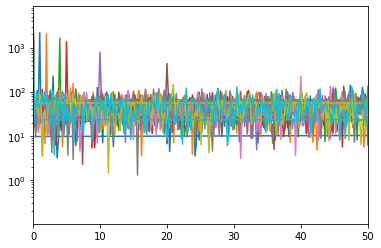

In [318]:
gain = []
x = np.arange(0,tstop,1.0/samp)

for i in range(10):
    fstm = stm[i]
    flat = rflat/fstm/2
    tilt = (1-rflat)/4/fstm
    x, y = GetSignal(x,tilt,flat,fstm)     
    plotFFT(x,y)
    #plt.plot(x,y)
    gain.append(FindPeak(x,y))

In [319]:
f = stm
g1= np.array(gain)

In [320]:
def func(x,t,A):
    return  A/np.sqrt(1+(2*const.pi*t*x)**2)

[4.07970141e-02 2.27520222e+03]


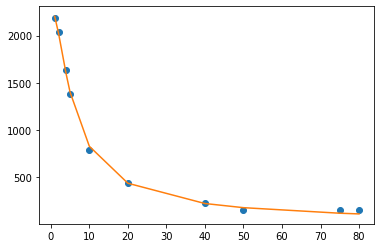

In [321]:
#initial parameters 
pinit=[tau, 1]

params,cov = optimize.curve_fit(func, f, g1,pinit)

print(params)

plt.plot(f,g1,'o')
plt.plot(f, func(f,params[0],params[1]))